In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "./spark-3.1.2-bin-hadoop2.7"
# get_ipython().system_raw('pip install pandas')
# get_ipython().system_raw('pip install findspark')
# get_ipython().system_raw('pip install matplotlib')
import findspark
findspark.init()

In [167]:
from pyspark.sql import SparkSession
import pandas as pd
spark = SparkSession.builder.appName(
    'A3 Análise de dados e Big Data').getOrCreate()

path = './data/clothes_db.csv'
roupas = spark.read.csv(path, sep=',')
roupas = roupas.fillna("Sem avaliação")

In [168]:
roupasColNames = [
    'titulo', 
    'preco_original', 
    'desconto_percentual', 
    'preco_com_desconto', 
    'quantidade_vendida', 
    'marca', 
    'material',
    'genero',
    'temporada',
    'nota_satisfacao',
    'quantidade_avaliações'
]
for index, colname in enumerate(roupasColNames):
    roupas = roupas.withColumnRenamed(f"_c{index}", colname)
roupas.printSchema()

root
 |-- titulo: string (nullable = false)
 |-- preco_original: string (nullable = false)
 |-- desconto_percentual: string (nullable = false)
 |-- preco_com_desconto: string (nullable = false)
 |-- quantidade_vendida: string (nullable = false)
 |-- marca: string (nullable = false)
 |-- material: string (nullable = false)
 |-- genero: string (nullable = false)
 |-- temporada: string (nullable = false)
 |-- nota_satisfacao: string (nullable = false)
 |-- quantidade_avaliações: string (nullable = false)



In [186]:
from pyspark.sql.functions import col

def get_sliced_data(company_name:str) -> pyspark.sql.dataframe.DataFrame :
    return roupas.select("*").where(col("marca").contains(company_name))

marcas_escolhidas = {
    "Adidas":  get_sliced_data("adidas"),
    "Lupo": get_sliced_data("Lupo"),
    "Mizuno":get_sliced_data("Mizuno"),
    "Mormaii":get_sliced_data("Mormaii"),
    "Fila":get_sliced_data("Fila"),
    "John John":get_sliced_data("John John"),
    "Keeper":get_sliced_data("Keeper"),
    "Levi's":get_sliced_data("Levi's"),
    "New Era":get_sliced_data("New Era"),
    "Olympikus":get_sliced_data("Olympikus"),
    "Puma":get_sliced_data("Puma"),
    "Under Armour": get_sliced_data("Under Armour")
}
dados = (
    marcas_escolhidas["Adidas"]
    .union(marcas_escolhidas["Lupo"])
    .union(marcas_escolhidas["Mizuno"])
    .union(marcas_escolhidas["Mormaii"])
    .union(marcas_escolhidas["John John"])
    .union(marcas_escolhidas["Keeper"])
    .union(marcas_escolhidas["Levi's"])
    .union(marcas_escolhidas["New Era"])
    .union(marcas_escolhidas["Olympikus"])
    .union(marcas_escolhidas["Puma"])
    .union(marcas_escolhidas["Under Armour"])
    )
dados.show(10000)

+--------------------+--------------+-------------------+------------------+------------------+------------+--------------------+----------+--------------------+---------------+---------------------+
|              titulo|preco_original|desconto_percentual|preco_com_desconto|quantidade_vendida|       marca|            material|    genero|           temporada|nota_satisfacao|quantidade_avaliações|
+--------------------+--------------+-------------------+------------------+------------------+------------+--------------------+----------+--------------------+---------------+---------------------+
|Short Saia Femini...|     R$ 312.79|                36%|         R$ 229.99|                 1|      adidas|            Elastano|  Feminino|      Outono/Inverno|  Sem avaliação|                    0|
|Short Masculino a...|     R$ 349.99|                 0%|         R$ 349.99|                 4|      adidas|            Elastano| Masculino|      Outono/Inverno|  Sem avaliação|                    0|


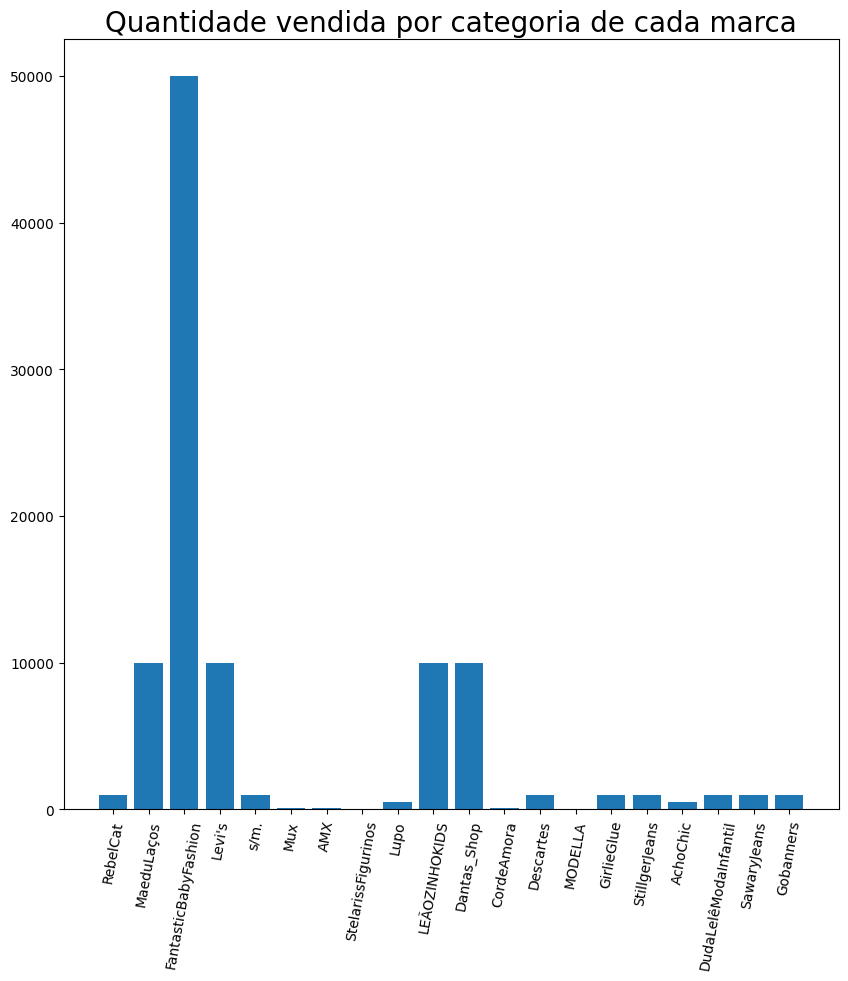

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

valores_x = [
    row[0].replace(' ', '') for row in
    roupas.distinct().limit(20).select("marca").collect()
]
valores_y = [
    float(row[0]) for row in
    roupas.na.drop("any").limit(20).select("n_vendidos_categoria").collect()
]




plt.figure(figsize=(10,10))
plt.title("Quantidade vendida por categoria de cada marca", fontsize=20)
plt.bar(valores_x, valores_y)
plt.xticks(rotation=80)
plt.show()


In [ ]:
get_ipython().system_raw('pip install squarify')

/home/thiago/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2607: UserWarning: You executed the system command !pip which may not work as expected. Try the IPython magic %pip instead.
  warnings.warn(


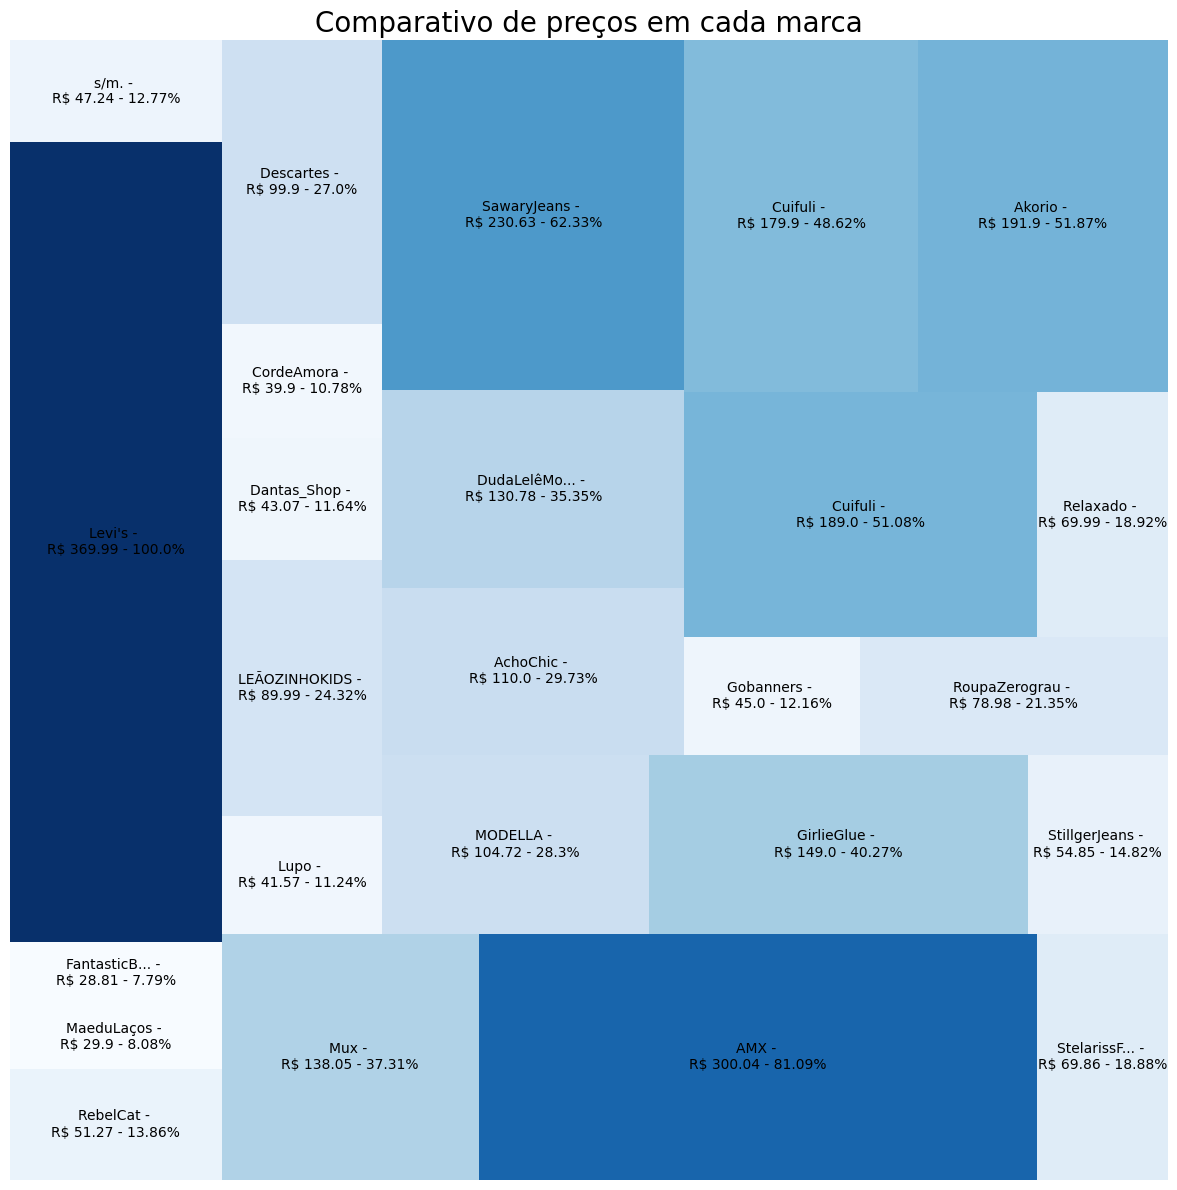

In [ ]:
import matplotlib
import squarify


marcas = [
    row[0].replace(' ', '') for row in
    roupas.distinct().limit(25).select("marca").collect()
]
precos = [
    float(row[0].replace(' R$ ', '').replace(' ','').replace(',','.')) for row in
    roupas.distinct().limit(25).select("preco_original").collect()
]
porcentagens = [
    round((float(row[0].replace(' R$ ', '').replace(' ','').replace(',','.')) * 100) / max(precos),2) for row in
    roupas.distinct().limit(25).select("preco_original").collect()
]
valores_x = [
    (marcas[index] if len(marcas[index]) < 15 else marcas[index][:10] + "...") + " - \n" +
    "R$ " + str(precos[index]) + " - " +
    str(porcentagens[index]) + "%"
    for (index, row) in 
    enumerate(roupas.distinct().limit(25).select("preco_original").collect())
]
# Definindo a paleta de cores para o treemap
cmap = matplotlib.cm.Blues

mini = min(valores_y)
maxi = max(valores_y)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(i)) for i in valores_y]


plt.figure(figsize=(12, 12))
grafico = squarify.plot(sizes=porcentagens, label=valores_x, color=colors)
plt.axis('off');
plt.title('Comparativo de preços em cada marca', fontsize=20)
plt.tight_layout()

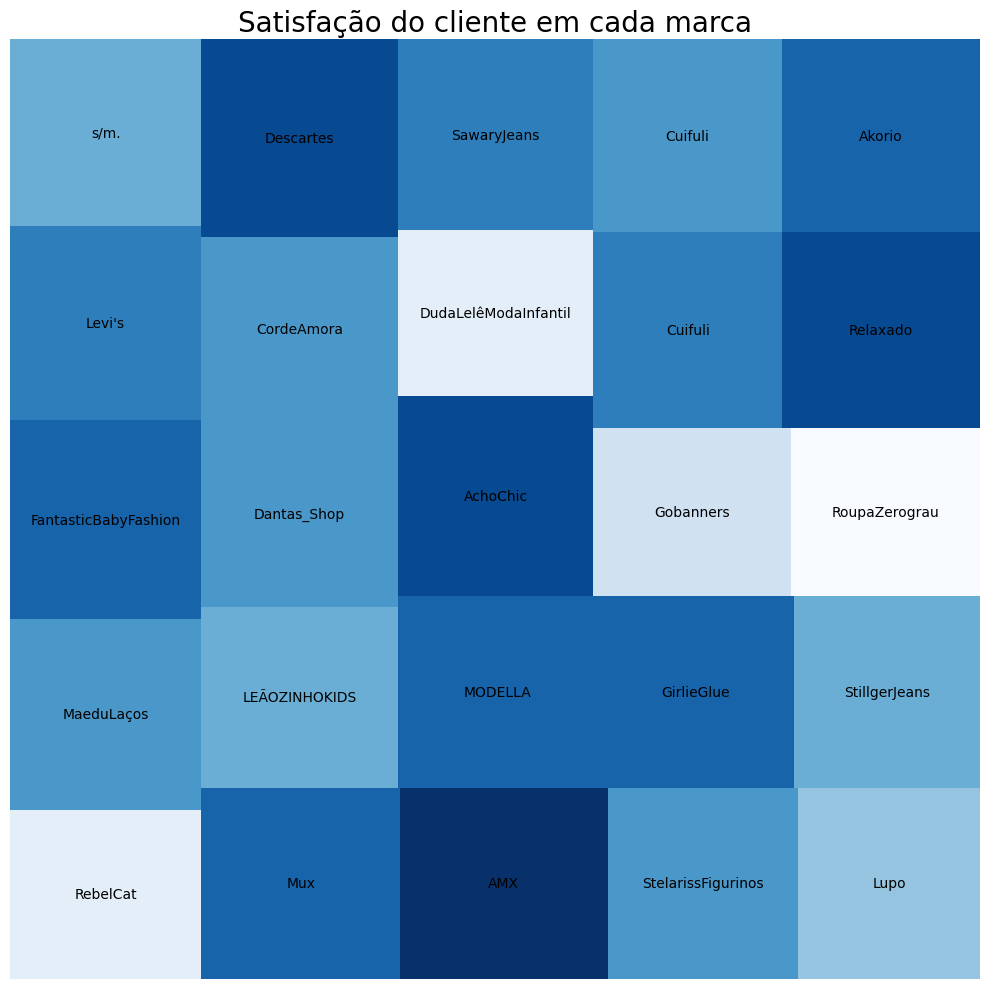

In [ ]:
import matplotlib
import squarify

valores_y = [
    float(row[0].replace(',','.')) for row in
    roupas.limit(25).select("nota").collect()
]
valores_x = [
    row[0].replace(' ', '') for row in
    roupas.distinct().limit(25).select("marca").collect()
]
# Definindo a paleta de cores para o treemap
cmap = matplotlib.cm.Blues
mini = min(valores_y)
maxi = max(valores_y)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(i)) for i in valores_y]

plt.figure(figsize=(10, 10))
squarify.plot(sizes=valores_y, label=valores_x, color=colors);
plt.title('Satisfação do cliente em cada marca', fontsize=20)
plt.axis('off');
plt.tight_layout()

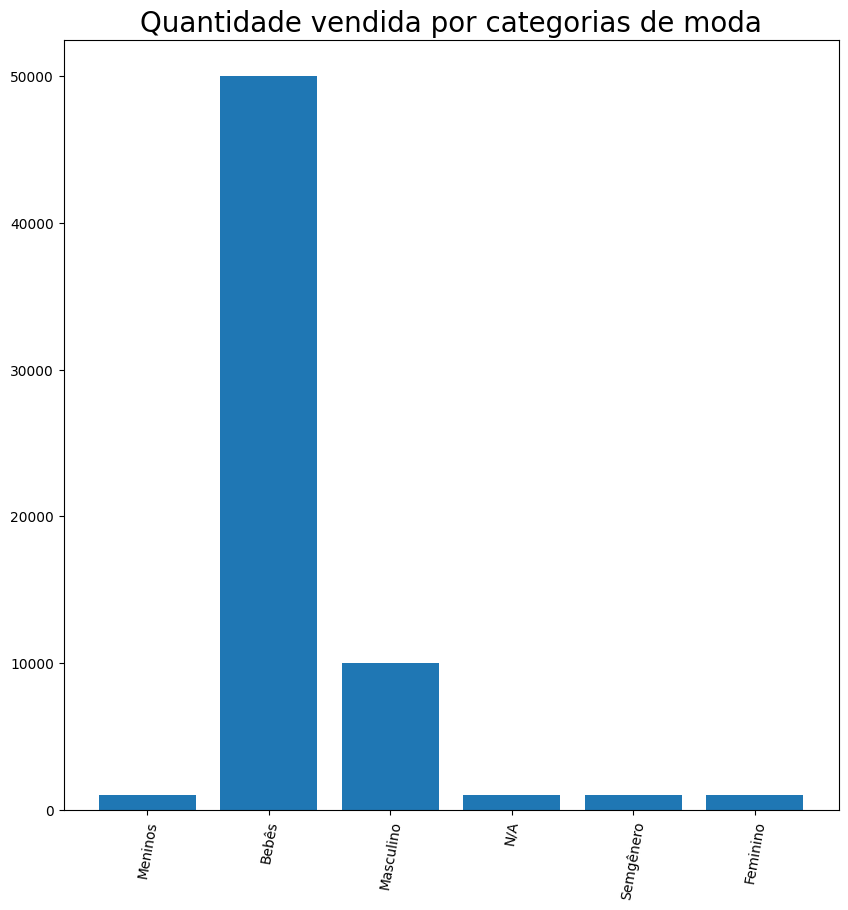

In [ ]:
valores_x = [
    row[0].replace(' ', '') for row in
    roupas.distinct().limit(20).select("gênero").collect()
]
valores_y = [
    float(row[0]) for row in
    roupas.na.drop("any").limit(20).select("n_vendidos_categoria").collect()
]
plt.figure(figsize=(10,10))
plt.title("Quantidade vendida por categorias de moda", fontsize=20)
plt.bar(valores_x, valores_y)
plt.xticks(rotation=80)
plt.show()

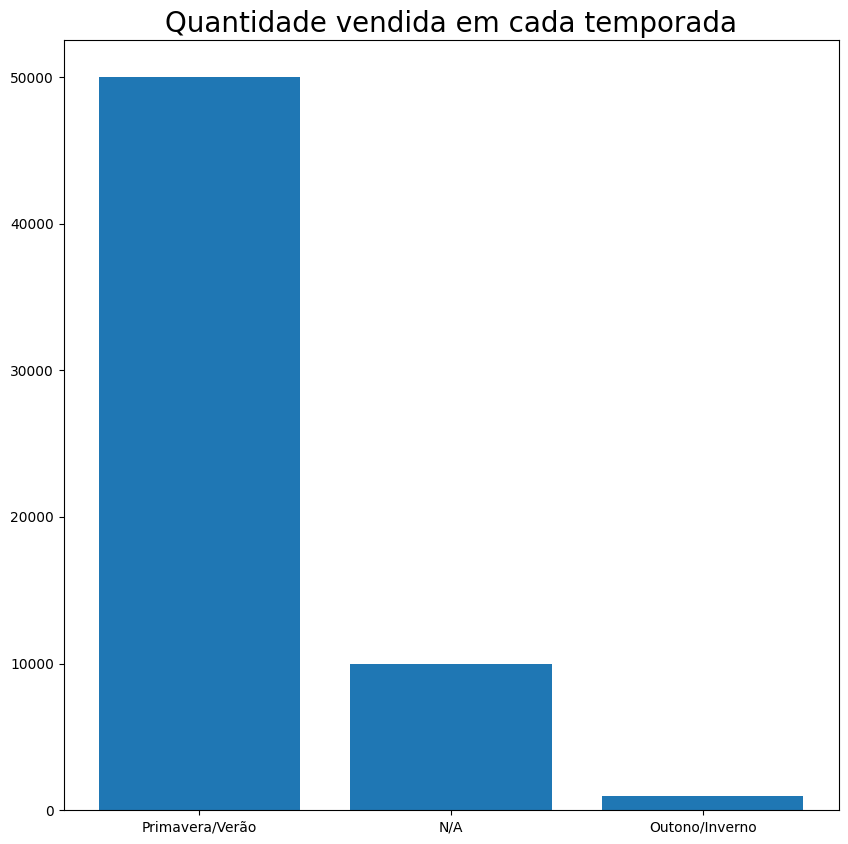

In [ ]:
import matplotlib
import squarify
valores_x = [
    row[0].replace(' ', '') for row in
    roupas.distinct().limit(20).select("temporada").collect()
]
valores_y = [
    float(row[0]) for row in
    roupas.na.drop("any").limit(20).select("n_vendidos_categoria").collect()
]
# Definindo a paleta de cores para o treemap
cmap = matplotlib.cm.Blues
maxi = max(valores_y)
norm = matplotlib.colors.Normalize(vmin=0, vmax=maxi)
colors = [cmap(norm(i)) for i in valores_y]

plt.figure(figsize=(10, 10))
plt.title("Quantidade vendida em cada temporada", fontsize=20)
plt.bar(valores_x, valores_y)
plt.show()